## Import Libraries Packages, Downloads

In [2]:
#manipulation and plotting libraries
import numpy as np
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import math as mt


warnings.filterwarnings('ignore')

/Users/omarafifi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/omarafifi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Loading and Formatting Data
`Note: (Because none of the cleaning we are doing involves imputation or such, we are doing the processing before the split)`

In [3]:
#warnings.filterwarnings('ignore')
Data = pd.read_csv('formatted_data.csv')

## Plotting

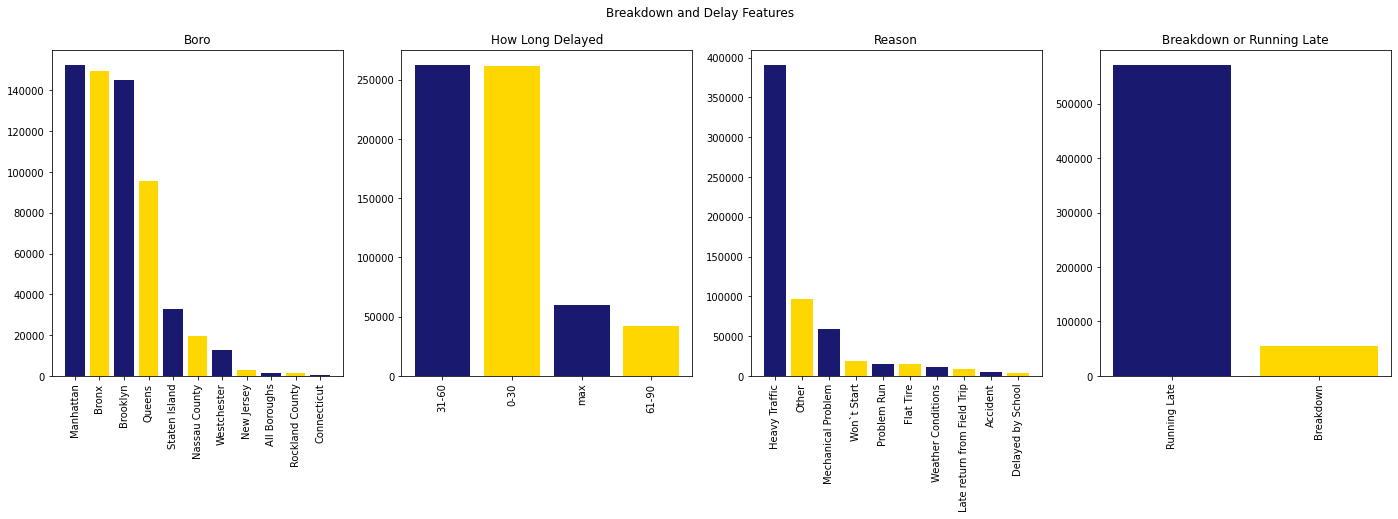

In [4]:
#warnings.filterwarnings('ignore')
columns_to_plot_Data = ['Boro','How_Long_Delayed' ,'Reason', 'Breakdown_or_Running_Late']

fig, axs = plt.subplots(1,4, figsize=(24, 6))
fig.suptitle("Breakdown and Delay Features")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()

colors = ['midnightblue', 'gold']
i = 0
for column_name in columns_to_plot_Data:

    counts = Data[column_name].value_counts()
    
    # Rotate the tick labels in the second subplot
    axs[i].bar(counts.index, counts.values, color = colors)
    axs[i].set_title(f"{column_name.replace('_', ' ')}")
    axs[i].set_xticklabels(counts.index, rotation=90)
    i += 1

#plt.savefig('breakdown_figures.pdf', bbox_inches = "tight")



In [12]:
def process(df): 

    #copy dataframe
    data = df.copy()
    #data.columns = data.columns.astype(str)

    #making a dictionary since we need to do a lot of conversion
    to_binary = {'Yes':1, 'No':0}

    #dropping columns we won't be able to use
    data = data.drop(['Busbreakdown_ID', 'Created_On', 
            'Informed_On','Incident_Number', 
            'Last_Updated_On', 'School_Age_or_PreK', 
            'School_Year', 'Route_Number', 'Schools_Serviced',
            'Run_Type', 'Bus_No', 'Bus_Company_Name'], axis = 1)
    
    data = data.dropna()

    #mapping literals to binary values
    data['Breakdown_or_Running_Late'] = data['Breakdown_or_Running_Late'].map({'Breakdown':1, 'Running Late':0})
    data['Has_Contractor_Notified_Parents'] = data['Has_Contractor_Notified_Parents'].map(to_binary)
    data['Has_Contractor_Notified_Schools'] = data['Has_Contractor_Notified_Schools'].map(to_binary)
    data['Have_You_Alerted_OPT'] = data['Have_You_Alerted_OPT'].map(to_binary)

    #getting month/date values
    data['Occurred_On'] = pd.to_datetime(data['Occurred_On'])
    data['Year'] = data['Occurred_On'].dt.year
    data['Month'] = data['Occurred_On'].dt.month
    data['Day'] = data['Occurred_On'].dt.day
    data['Hour'] = data['Occurred_On'].dt.hour
    data['Mins'] = data['Occurred_On'].dt.minute
    data['Weekday'] = data['Occurred_On'].dt.weekday


    data["sin_month"] = np.sin(2*np.pi*data["Month"]/max(data["Month"]))
    data["cos_month"] = np.cos(2*np.pi*data["Month"]/max(data["Month"]))
    data["sin_hour"] = np.sin(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["cos_hour"] = np.cos(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["sin_mins"] = np.sin(2*np.pi*data["Mins"]/max(data["Mins"]))
    data["cos_mins"] = np.cos(2*np.pi*data["Mins"]/max(data["Mins"]))

    #one hot encode boro
    #data['Boro'] = data['Boro'].fillna('None')
    for boro in data['Boro'].unique():
        data[boro] = (data['Boro'] == boro).astype(int)

    # one hot encode breakdown reason
    for reason in data['Reason'].unique():
        data[reason] = (data['Reason'] == reason).astype(int)

    data = data.drop(['Boro'], axis = 1)
    data = data.drop(['Reason'], axis = 1)

    #plot some features

    i = 0
    columns_to_plot_df = ['Month', 'Day', 'Hour', 'Weekday']

    fig, axs = plt.subplots(1,4, figsize=(24, 4))
    fig.suptitle("Time Series Features")
    fig.subplots_adjust(hspace = .5, wspace=.2)
    axs = axs.ravel()
    colors = ['midnightblue', 'gold']

    for column_name in columns_to_plot_df:
        
        counts = data[column_name].value_counts().sort_index()
        
        # Rotate the tick labels in the second subplot
        axs[i].bar(counts.index, counts.values, color = colors)
        axs[i].set_title(f"{column_name}")
        i += 1

    data = data.drop(['Occurred_On', 'Month', 'Day', 'Hour', 'Mins'], axis = 1)

    #plt.savefig('Time_features.pdf', bbox_inches = "tight")

    return data


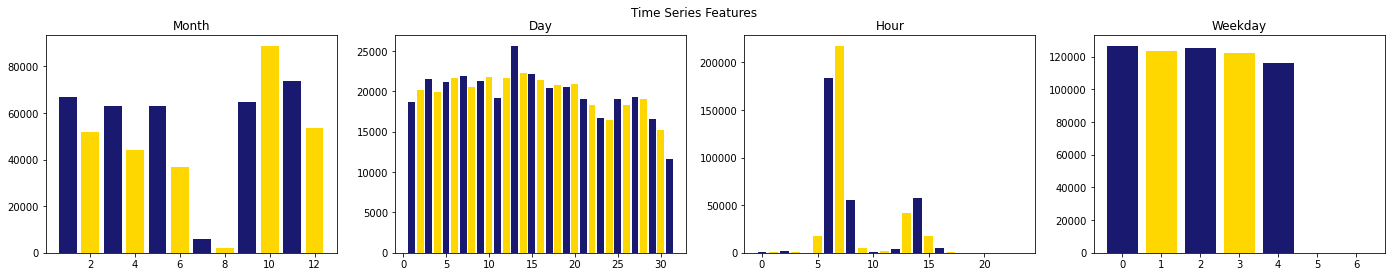

In [13]:
#Process the data
df = process(Data)


## Train Test Split

In [16]:
from itertools import combinations

#get all combinations of classes
pairs = list(combinations(np.unique(df['How_Long_Delayed']),2))

classes = {0:'0-30', 1: '31-60', 2:'61-90', 3:'91-120', 4:'max'}
inverse_classes = {'0-30':0, '31-60':1, '61-90':2, '91-120':3, 'max':4}

#this method takes all the pairwise choices of the labels and returns the classes
def pairwise_sets(df, pair_list):

    #getting the pairwise rows of the data frame
    pairings = {}

    for pair in pair_list:

        all_rows_with_labels = df.loc[(df['How_Long_Delayed'].isin(pair))]

        y = all_rows_with_labels['How_Long_Delayed']
        X = all_rows_with_labels.drop(['How_Long_Delayed'], axis = 1)

        pairings[pair] = [X,y] 
    return(pairings)

In [37]:
# split data into training and testing data at a .9 ratio
training_data = df.sample(frac = .9)
testing_data = df.drop(training_data.index)

# then break the data up into groups
training_paired = pairwise_sets(training_data, pairs) 
testing_paired= pairwise_sets(testing_data, pairs)

#testing sets together fro the combined models
y_test = testing_data['How_Long_Delayed']
X_test = testing_data.drop('How_Long_Delayed', axis = 1)


# Machine Learning



In [18]:
#ML libraries
#warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

## Baseline Logistic Regression Individual Classifiers

In [ ]:
## Baseline Logistic Regression 
models_baseline = {}

for pair in pairs:

    (X_train, y_train) = training_paired[pair]


    to_binary = {pair[0]:0, pair[1]:1}
    y_train = y_train.map(to_binary)
    
    
    pipe = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree = 1)),
            ('mod', LogisticRegression())

        ])

    grid_cv = GridSearchCV(pipe, 
                        param_grid=
        {
            'mod': [ LogisticRegression()],
            'scaler': [StandardScaler()],
            'poly__degree': [1],

        },
        verbose = 1,
        cv = 2,
        return_train_score= True
    )
    
    grid_cv.fit(X_train, y_train)

    best_estimator = grid_cv.best_estimator_

    models_baseline[pair] = best_estimator

## Building The Random Forrest Classifiers



In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [60]:
models = {}

for pair in pairs:

    (X_train, y_train) = training_paired[pair]


    to_binary = {pair[0]:0, pair[1]:1}
    y_train = y_train.map(to_binary)


    best_params = {
    'max_depth': 30,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 200}

    model = RandomForestClassifier(**best_params)
    model.fit(X_train, y_train)

    models[pair] = model



## Assembly
This class takes the pretrained binary classifiers and turns them into a one vs one classifier.

In [61]:
class ovo:
    
    #constructor takes in an collection of classifiers
    def __init__(self, models):
        
        self.models = models
        self.pairs = list(combinations(np.unique(df['How_Long_Delayed']),2))
        self.classes = {0:'0-30', 1: '31-60', 2:'61-90', 3:'91-120', 4:'max'}
        self.inverse_classes = {'0-30':0, '31-60':1, '61-90':2, '91-120':3, 'max':4}

    def predict(self, data):

        #output of model
        output = []

        #loop through the data
        for index, row in data.iterrows():
            #dictionary for keeping track of counts
            counts = {'0-30':0, '31-60':0, '61-90':0, '91-120':0, 'max':0}
            #iterate through all pairs
            for pair in self.pairs:

                #get the classifier for that pair
                classifier = self.models[pair]

                #the classifier will think pair[0] is the 0 class and 
                #pair[1] is the positive class so we add to the counts accordingly. 
                prediction = classifier.predict(row.to_numpy().reshape(1,-1))

                #add the count to the appropriate class
                if prediction == 1:
                    counts[pair[1]] += 1
                else:
                    counts[pair[0]] += 1

            # add the class with the most votes to the output
            output.append(max(counts, key=counts.get))

        return np.array(output)


In [62]:
#get predictions from the assembled model
ov1 = ovo(models)
y_pred = ov1.predict(X_test)

## Evaluation

In [13]:
# Libraries
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
import statistics as stat
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

### Evaluation For the Combined Models

In [ ]:

combined_scores = pd.DataFrame()

combined_scores['Accuracy'] = [balanced_accuracy_score(y_test, y_pred)]
combined_scores['Recall'] =  [recall_score(y_test, y_pred, average= 'micro')]
combined_scores['Precision'] = [precision_score(y_test, y_pred, average= 'micro')]
combined_scores['F1'] = [f1_score(y_test, y_pred, average= 'micro')]

combined_scores.round(4).to_csv('micro_scores_random_forrest.csv', index=False)

#### Making ROC and Precision Recall Curves

NOTE: these cells should not be run if the previous cell was ran ... this could cause data leakage.

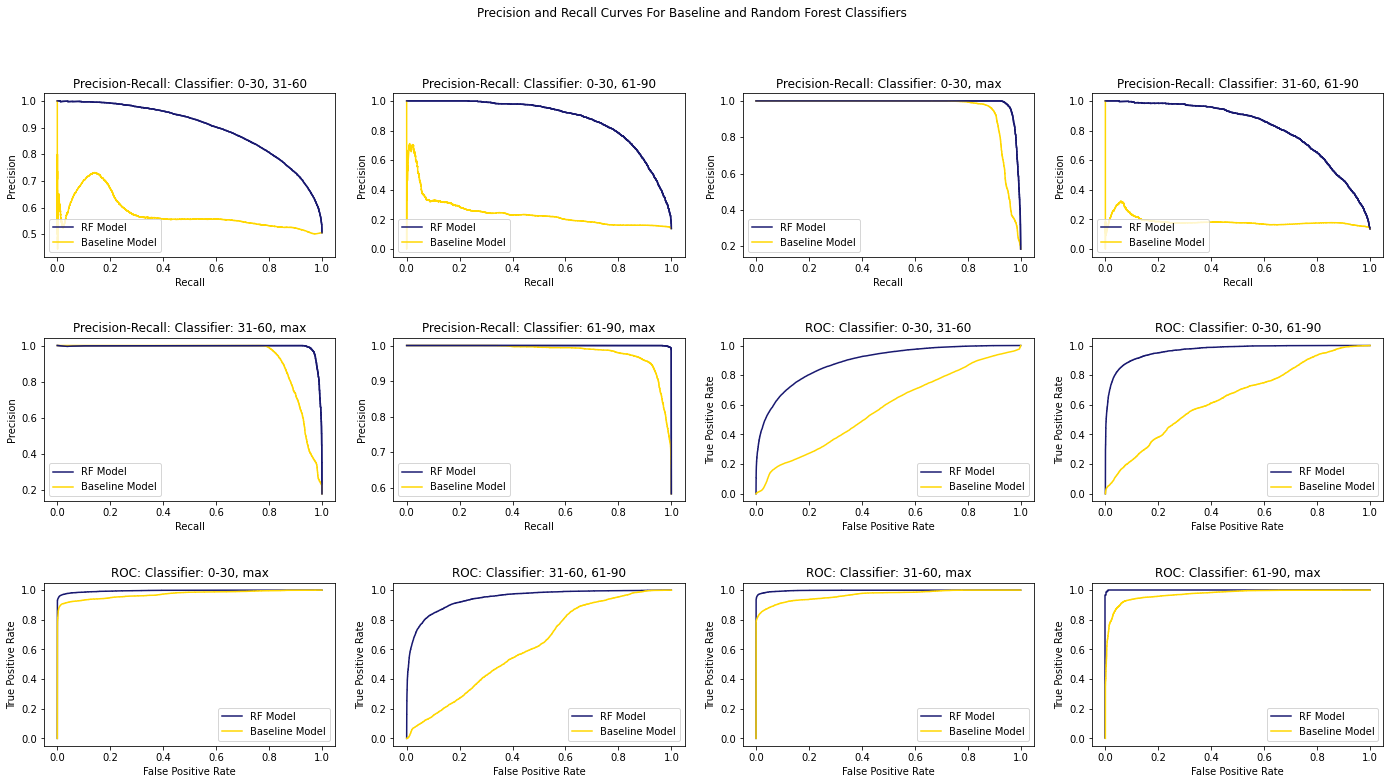

In [23]:

fig, axs = plt.subplots(3,4, figsize=(24, 12))

fig.suptitle("Precision and Recall Curves For Baseline and Random Forest Classifiers")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
colors = ['midnightblue', 'gold']

i = 0
for pair in pairs:
    
    (X_test, y_test) = testing_paired[pair]
    to_binary = {pair[0]:0, pair[1]:1}

    #classifier scores 
    classifier = models[pair]

    y_pred_model = classifier.predict(X_test)
    y_test = y_test.map(to_binary)

    prec_score = precision_score(y_test, y_pred_model)
    rec_score = recall_score(y_test, y_pred_model)
    y_pred_probs = classifier.predict_proba(X_test)[:,1]
    precision, recall, threshholds = precision_recall_curve(y_test, y_pred_probs)

    #baseline scores 
    baseline_classifier = models_baseline[pair]

    y_pred_baseline = baseline_classifier.predict(X_test)
    y_pred_probs_baseline = baseline_classifier.predict_proba(X_test)[:,1]

    baseline_recall_score = recall_score(y_test, y_pred_baseline)
    baseline_precision_score = precision_score(y_test, y_pred_baseline)

    baseline_precision, baseline_recall, baseline_threshholds = precision_recall_curve(y_test, y_pred_probs_baseline)

    axs[i].plot(recall, precision, color = 'midnightblue', label = f"RF Model")
    axs[i].plot(baseline_recall, baseline_precision, color = 'gold', label = f"Baseline Model")
    axs[i].plot(recall, precision, color = 'midnightblue')

    axs[i].set_title(f"Precision-Recall: Classifier: {pair[0]}, {pair[1]}")
    axs[i].set_xlabel('Recall')
    axs[i].set_ylabel('Precision')
    axs[i].legend(loc = 'lower left')
    i += 1


i = 6

for pair in pairs:
    
    #rf classifier
    classifier = models[pair]

    (X_test, y_test) = testing_paired[pair]
    y_pred = classifier.predict_proba(X_test)[:,1]

    to_binary = {pair[0]:0, pair[1]:1}
    y_test = y_test.map(to_binary)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    #baseline classifier
    baseline_classiffier = models_baseline[pair]

    y_pred_baseline = baseline_classiffier.predict_proba(X_test)[:,1]
    baseline_auc = roc_auc_score(y_test, y_pred_baseline)
    baseline_fpr, baseline_tpr, baseline_threshholds = roc_curve(y_test, y_pred_baseline)



    axs[i].plot(fpr, tpr,  color = 'midnightblue', label = f"RF Model")
    axs[i].plot(baseline_fpr, baseline_tpr,  color = 'gold', label = f"Baseline Model")
    axs[i].set_title(f"ROC: Classifier: {pair[0]}, {pair[1]}")
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc = 'lower right')

    i += 1

plt.savefig('ROC_Curves.pdf', bbox_inches = "tight")
plt.show()


### Individual Estimator and Micro-Averaged Scores

In [20]:
## Metrics # Macro

pairs = list(combinations(np.unique(df['How_Long_Delayed']),2))


f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

scores = pd.DataFrame()

from sklearn.metrics import RocCurveDisplay

for pair in pairs:
    
    classifier = models[pair]

    (X_test, y_test) = testing_paired[pair]
    y_pred = classifier.predict(X_test)
    y_pred_probs = classifier.predict_proba(X_test)[:,1]

    to_binary = {pair[0]:0, pair[1]:1}
    y_test = y_test.map(to_binary)

    auc_scores.append(roc_auc_score(y_test, y_pred_probs))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

#average scores

scores['Classifier Pair'] = pairs
scores['Accuracy'] = accuracy_scores
scores['Recall'] = recall_scores
scores['Precision'] = precision_scores
scores['F1'] = f1_scores
scores['AUC'] = auc_scores

scores.round(4).to_csv('random_forrest_metrics.csv', index=False)


